# Business Profile Vector Creation
<p>This script file transforms the yelp business table into a <b>binary representation matrix</b> that contains attribute values (features) as columns and businesses as rows.  Each element in this matrix contains either 1/0 indicating whether or not a business has an attribute.</p>
<p>The binary representation of the existence of features for a business will act as the <b>TF (Term Frequency)</b> for each feature.  This method was chosen over obtaining frequency counts for each feature because it works better for this type of data: where a business can either have a certain feature or not.  Since businesses aren't text documents, obtaining frequency counts wouldn't make much sense.</p>
<p>Ultimately, this script file will normalize the binary representation matrix by transforming all vector lengths to 1.  After normalization, the <b>IDF (Inverse Document Frequency)</b> weights will be applied to each business in the binary matrix to weigh down features that occurr frequently in the corpus. Lastly, each row in the IDF weighted matrix will act as a business profile indicating the types of features it has.</p>
<p>These business profiles will act as search results where the user profiles are the query.  The closest match to the query (user profile) will be obtained from the cosine of the angle between the user profile vector and business profile vector.  These matches will then act as recommendations to the user and will be sorted in descending order based on the cosine (closest match first).</p>

## Libraries, functions, and globals

In [1]:
import mysql.connector
import json
import csv
import re
import numpy as np
import pandas as pd
import dask.dataframe as dd
import multiprocessing as mp
from pandas.io.json import json_normalize
from itertools import chain
import matplotlib.pyplot as plt

calc_field_count = 0

host = "localhost"
un = "root"
pw=""
db_name = "yelp"

fp = "C:/Users/Tolis/Documents/Data Analytics Cource/CKME136 X10/Project/data/final/profiles"
fn = "business_profiles"


def mysql_result_to_df(result, cursor):
    field_names = [i[0] for i in cursor.description]
    return pd.DataFrame(result, columns=field_names)

def flatten_json(y):
    """
    Converts complex/nested JSON to table format.
    """
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

def df_to_csv(df, fp, ext=".csv", na_rep=""):
    try:
        df.to_csv(fp + ext, encoding="utf-8", header = True,\
            doublequote = True, sep=",", index=False, na_rep=na_rep)
    except Exception as e:
        print("Error: {}".format(str(e)))
        
"""
    The functions below are used to transform yelp json object literals
    to a usable value such as a count, or a boolean True/False.
"""

def yelp_json_list_format(ylist):
    result = (str(ylist).replace("'", "\""))
    result = (result.replace("True", "\"True\""))
    result = (result.replace("False", "\"False\""))
    return result
    
def get_yelp_list_keys(val):
    """
    Returns keys from a obj lit if their values evaluate to True.
    """

    result = yelp_json_list_format(val)
    true_keys = []
    try:
        result = json.loads(result)
        
        for k,v in result.items():   
            if(v != "" and v!=False and v!="False"): 
                true_keys.append(k)
        return true_keys
    except:
        return float('nan')
    
def yelp_str_to_list(val):
    """
    Splits a comma sep. string to list and returns it.
    """
    try:
        result = val.split(", ")
        if(len(result)==1 and result[0]=="{}"):
            return result[0]
        for i,v in enumerate(result):
            result[i] = result[i].strip().lower()
            result[i] = re.sub(r"\s+","-", result[i])
            result[i] = re.sub(r"&","and", result[i])
        return result
    except:
        return float('nan')
    
def get_yelp_loc(row):
    city = row["city"]
    city = re.sub(r"\s+","-", city)
    return [city.lower() + "-" + row["state"].lower()]
    
def flatten_list(l):
    return list(chain.from_iterable(l))

def normalize_text(x):
    result = str(x)
    result = re.sub(r"[\[\]\"\n,'\\]", "", result)
    result = re.sub(r"\s{2,}", " ", result)
    result = result.lower().strip()
    return result

npartitions = 4 * mp.cpu_count()

## Load business table and flatten attributes field
<p>The attribute field in the yelp business table is formatted as json and needs to be flattened (transformed to table format) to utilize these features in the model.</p>

#### Connect to mysql and create dataframe from results

In [2]:
mydb = mysql.connector.connect(
  host=host,
  user=un,
  passwd=pw,
  database=db_name
)

mycursor = mydb.cursor()

mycursor.execute("SELECT * FROM business")

myresult = mycursor.fetchall()

business_df = mysql_result_to_df(myresult, mycursor)

#Stars gets imported as a string, so convert to decimal
business_df["stars"] = business_df["stars"].apply(lambda val: float(val))

print(business_df.info())

mycursor.close()
mydb.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
business_id     192609 non-null object
name            192609 non-null object
address         192609 non-null object
city            192609 non-null object
state           192609 non-null object
postal_code     192609 non-null object
latitude        192609 non-null float64
longitude       192609 non-null float64
stars           192609 non-null float64
review_count    192609 non-null int64
is_open         192609 non-null int64
attributes      192609 non-null object
categories      192609 non-null object
hours           192609 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB
None


#### Flatten and transform fields
<p>The attributes column is first extracted from the original business dataframe and then flattened. Additionaly, fields that have json objects as values are transformed to python lists.</p>

In [3]:
business_attributes = business_df["attributes"]
business_attributes_json = []

for r in business_attributes:
    r_json = json.loads(r)
    business_attributes_json.append(r_json)

business_attr_flat = json_normalize(business_attributes_json)


"""
Declare calculated fields for json object literal provided by yelp.
These object literals contain multiple keys that map to boolean values (for the most part). 

Example:

Field: BusinessParking
Value: "{'garage': True, 'street': False, 'validated': False, 'lot': True, 'valet': False}"

Transforming these objects to a list of categores, a single number (count), or a boolen field makes them easier to analyze.
Example Transfromation of BusinessParking using count:

Field: BusinessParking_Count
value: 2 (count all True values)
"""

business_attr_flat["CALC_BusinessParking_Options"] = business_attr_flat["BusinessParking"].apply(get_yelp_list_keys)
business_attr_flat["CALC_GoodForMeal_Options"] = business_attr_flat["GoodForMeal"].apply(get_yelp_list_keys)
business_attr_flat["CALC_Music_Options"] = business_attr_flat["Music"].apply(get_yelp_list_keys)
business_attr_flat["CALC_BestNights_Options"] = business_attr_flat["BestNights"].apply(get_yelp_list_keys)
business_attr_flat["CALC_Ambience_Options"] = business_attr_flat["Ambience"].apply(get_yelp_list_keys)
business_attr_flat["CALC_DietaryRestrictions_Options"] = business_attr_flat["DietaryRestrictions"].apply(get_yelp_list_keys)
business_attr_flat["CALC_HairSpecializesIn_Options"] = business_attr_flat["HairSpecializesIn"].apply(get_yelp_list_keys)


transformed_fields = ["BusinessParking", 
                      "GoodForMeal",
                      "Music",
                      "BestNights",
                      "Ambience",
                      "DietaryRestrictions",
                      "HairSpecializesIn"]

calculated_fields = ["CALC_BusinessParking_Options",
                   "CALC_GoodForMeal_Options",
                   "CALC_Music_Options",
                   "CALC_BestNights_Options",
                   "CALC_Ambience_Options",
                   "CALC_DietaryRestrictions_Options",
                   "CALC_HairSpecializesIn_Options"]


print("Transformed:",", ".join(transformed_fields))


Transformed: BusinessParking, GoodForMeal, Music, BestNights, Ambience, DietaryRestrictions, HairSpecializesIn


#### Drop fields that have been transformed and concat flattened attributes to original data
<p>Drop the fields that hold json values since we'll be using their transformed values.  The new fields that hold the transformed values have been prefixed with 'CALC_'.</p>

In [4]:
business_attr_flat = business_attr_flat.drop(transformed_fields, axis=1)


business_df = pd.concat([business_df,business_attr_flat], axis=1)

#Create calculate field here instead of above to keep it at the end of the dataframe
#business_df["CALC_DaysOpen"] = business_df["hours"].apply(get_yelp_list_keys)
business_df["CALC_Categories"] = business_df["categories"].apply(yelp_str_to_list)

#calculated_fields.append("CALC_DaysOpen")
calculated_fields.append("CALC_Categories")

business_df = business_df.drop(["hours"], axis=1)
business_df = business_df.drop(["attributes"], axis=1)
business_df = business_df.drop(["categories"], axis=1)

#All things consisdered as possible nulls converted to actual nulls
business_df = business_df.replace(r'^\s*$', np.nan, regex=True)
business_df = business_df.replace(r'^\{\}$', np.nan, regex=True)

#### Flatten fields that contain list elements as values to obtain them as features for the binary matrix
<p>The goal is to obtain a one level (flattened) list that contains unique values for all features obtained from the caclulated fields in the code block above.  Each 'CALC_' field holds python lists as their values, which will be broken down into single elements, and any duplicate elements found from a specific calculated field will be removed.</p>
<p>The last step is to concatenate all unique single elements found from the calculated fields into one list, and use this as the column labels for the binary matrix. A mapping table will also be created to map list slices (for the flattened list of features) to their associated fields.</p>

In [5]:
# The binary matrix will contain a column for each unique feature found.
# The rows will represent businesses, and each cell will be 1/0 indicating if that business has this feature.

# Obtain new df of just the calculated fields from the bussiness df
calc_field_count = len(calculated_fields)
calc_fields = list(business_df.columns)
calc_fields = calc_fields[-calc_field_count:]
df_calc_fields = business_df[calc_fields]

# Stores all unique values found in calculated columns
bin_cols = []

# Stores a mapping table that assists in the logic for the creation of the binary matrix
field_map = []

# Loop through each calculated column
for name, values in df_calc_fields.iteritems():
    
    # Remove null rows from calc column since they are not needed for the bin matrix
    reduced = pd.Series(values)
    no_nulls = reduced.notnull()
    reduced = reduced[no_nulls]
    
    # Convert values in calc column (which are lists) to string
    # Doing this makes it possible to obtain unique values from this column
    reduced = reduced.astype(str)
    reduced = reduced.unique().tolist()
    
    # Append unique values found to bin_cols
    bin_cols.append(reduced)


# Loop through bin_cols values which are strings
# The goal is to split the strings into a list, 
# and only obtain unique single elements
for i,v in enumerate(bin_cols):
   
    # Remove any uneeded chars to obtain only values
    bin_cols[i] = normalize_text(v)
    
    # Split result to list by space and obtain unique values.
    # The normalization of text ensures text that had spaces was replaced with hyphens
    bin_cols[i] = bin_cols[i].split(" ")
    
    # convert to series to obtain unique elements easily
    bin_cols[i] = pd.Series(bin_cols[i])
    bin_cols[i] = bin_cols[i].unique()
    
    # append current field_name and unique count to field_map
    # which will be used as an index table to keep values together with what field they came from
    field_name = calculated_fields[i]
    val_count = len(bin_cols[i])
    field_map.append([field_name, val_count])

# Flatten bin cols to remove nested lists
bin_cols = flatten_list(bin_cols)

print(bin_cols[0:10])


['lot', 'garage', 'valet', 'street', 'validated', 'lunch', 'dinner', 'brunch', 'breakfast', 'dessert']


#### Create the mapping table that contains the names of the calculated fields, their unique counts, and start/end indexes for list slicing purposes
<p>This makes it easy to obtain slices of the bin_cols list when creating the boolean results further down in the code.</p>

In [6]:
field_map = pd.DataFrame(field_map, columns=["Field Name", "Unique Count"])

#defaults
start_at = 0
end_at = 0
result = []

for i,v in field_map["Unique Count"].items():
    if(end_at == 0):
        end_at = v - 1
    else:
        start_at = end_at + 1
        end_at = v + start_at - 1
    result.append([start_at, end_at])

result = pd.DataFrame(result, columns=["Index Start","Index End"])
field_map = pd.concat([field_map, result], axis=1)
print(field_map)

                         Field Name  Unique Count  Index Start  Index End
0      CALC_BusinessParking_Options             5            0          4
1          CALC_GoodForMeal_Options             6            5         10
2                CALC_Music_Options             6           11         16
3           CALC_BestNights_Options             7           17         23
4             CALC_Ambience_Options             9           24         32
5  CALC_DietaryRestrictions_Options             6           33         38
6    CALC_HairSpecializesIn_Options             8           39         46
7                   CALC_Categories          1300           47       1346


## Create the business profile matrix and save output to parquet

<p>*This script may take serveral minutes to complete since there are many features to check for.</p>

In [7]:
bin_data = []

# loop through rows in calculated fields
for i,row in df_calc_fields.iterrows():
    
    # Stores bool results from checking if features exist for current item
    bools = []
    
    # Loop through each field_name and value in current row.
    for k,v in row.items():   
        # Finds current row in field map
        which_field = field_map["Field Name"] == k
        
        # Get start and end cords for slicing the bin_cols list
        start = int(field_map["Index Start"][which_field])
        end = int(field_map["Index End"][which_field]) + 1
        
        # Slice bin cols list
        # This contains the list of boolean features to look for in the current field
        feat_values = bin_cols[start:end]
        
        # Make sure current value is a list
        if(isinstance(v, list) and len(v)>0):
            
            # Series created to utilize the isin method
            tmp_series = pd.Series(feat_values)
            
            # Normalize text before running the bool checks
            norm_vals = list(map(normalize_text, v))
            
            # Bool check for features in current field
            bool_result = tmp_series.isin(norm_vals).tolist()
           
           
            bools.append(bool_result)
            
        else:
            #if not a list then append all false values
            bools.append([False]*len(feat_values))
    
    # Flatten bools to treat all checks as a single row 
    bools = flatten_list(bools)
    # Append row for the bin matrix
    bin_data.append(bools)

#### Convert bin matrix to data frame and transform True/False to 1/0
<p>Converting the boolen True/False values to integer 1/0 values makes it possible to perform calculations on this data.</p>
<p>Additionally, the column sums of the matrix represent the DF for each feature.  This shows us how many businesses have a certain feature, which also allowed me to drop features that don't have many businesses assigned to them.  A cut-off point of atleast 10 businesses was created, and features that don't meet this threshhold will be dropped for feature reduction.</p>
<p>It was benificial to drop features from the binary matrix, as opposed to the original data, since the features in the bin matrix are single values obtained from list elements from the original data.  Because of this, I was able to drop single values from an attribute from the original data instead of dropping the entire attribute itself.</p>
<p>Lastly, there were some businesses that didn't have any attributes at all, meaning that their row sum was equal to 0.  I removed these businesses because they don't add any information (attribute wise) to the model.  A possible explanation for these businesses with 0 attributes is that the business itself didn't update their yelp information.</p>

In [8]:
df_bin_data = pd.DataFrame(bin_data, columns=bin_cols)
df_bin_data = df_bin_data.astype(int)

# Drop features that have less than 3 business that contain their value's
# This is to reduce the column size as well as to remove features that don't add much to the model
bin_data_col_sums = df_bin_data.sum(axis=0)

which_field = bin_data_col_sums < 10
drop_index = bin_data_col_sums[which_field].index.tolist()

df_bin_data = df_bin_data.drop(drop_index, axis=1)
bin_data_row_sums = df_bin_data.sum(axis=1)
which_rows = bin_data_row_sums == 0
df_bin_data = df_bin_data[~which_rows]

# Amount of columns to drop
print("cols dropped:", len(drop_index), "\nrows dropped", which_rows.astype(int).sum())

cols dropped: 217 
rows dropped 482


In [9]:
print(df_bin_data.info())
print(df_bin_data.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192127 entries, 0 to 192608
Columns: 1129 entries, lot to drive-in-theater
dtypes: int32(1129)
memory usage: 828.9 MB
None
(192127, 1129)


#### Insert business IDs to label each row
<p>The business ID's will be used for a join operation to the user review data.</p>

In [10]:
df_bin_data.insert (0, "business_id", business_df["business_id"])

df_bin_data.head()

,business_id,lot,garage,valet,street,validated,lunch,dinner,brunch,breakfast,...,shaved-snow,matchmakers,badminton,perfume,themed-cafes,misting-system-services,cideries,bike-tours,private-schools,drive-in-theater
0,--1UhMGODdWsrMastO9DZw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--6MefnULPED_I942VcFNA,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,--7zmmkVg-IMGaXbuVd0SQ,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,--8LPVSo5i0Oo61X01sV9A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,--9QQLMTbFzLJ_oT-ON3Xw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Remove duplicate field names in the binary matrix
<p>
These duplicates came from different fields that hold the same type of value.<br>
For example: the CALC_DaysOpen and CALC_BestNights_Options fields both hold lists of days (Mon-Sun), but represent different meanings.
</p>
<p>
This causes problems when saving to certain file formats, such as parquet.  To resolve this issue, I replace duplicate field names with an underscore.
</p>

In [11]:
# Get bool indexes of duplicated column names
dup_bool_indexes = df_bin_data.columns.duplicated()

# Get all column names
all_col_names= pd.Series(df_bin_data.columns.tolist())

# Append underscore to all dup column names
dup_field_names_fixed = all_col_names[dup_bool_indexes] + "_"

# Replace duplicates with underscore value
all_col_names[dup_field_names_fixed.index] = dup_field_names_fixed.values
df_bin_data.columns = all_col_names.tolist()

#### Save bin matrix and clean up variables that may be taking up memory

In [12]:
df_bin_data.to_parquet(fp + "/" + fn + ".gzip", compression="gzip")

#Clean Up
business_df = None
df_bin_data = None
bin_data = None
bin_cols = None

## Create a normalized and weighted version of the binary matrix for later use

#### Apply normalization
<p>The formula for normalization is: <b>x / sqrt(row_sum ^ 2)</b> where x=[0/1] and the row_sum=[total of all 1's for current row/business]. The square root of the row_sum represents the vector length.</p>

<p>Normalization is performed on the binary <em>(1/0)</em> values by dividing each element with its vector length. This causes each business profile vector to have a length of 1 and is done before the IDF weights are applied.</p>

In [13]:
def normalize_bin_data(row):
    num_vals = row.drop("business_id")
    result = num_vals / np.sqrt(sum(num_vals**2))
    return row[["business_id"]].append(result)



business_profs_df = pd.read_parquet(fp + "/" + fn + ".gzip")

business_profs_df["business_id"] = business_profs_df["business_id"].astype("category")
business_profs_df_nums = business_profs_df.drop(["business_id"], axis=1)

# Obtain DF (doc frequency) and IDF from the column sums of the business profiles
# This is done prior to normalization
docFreq_byCol = business_profs_df_nums.sum(axis=0)
docFreq_total = business_profs_df["business_id"].values.tolist()
docFreq_total = len(docFreq_total)

inverse_docFreq_byCol = docFreq_total / (docFreq_byCol)
inverse_docFreq_byCol = inverse_docFreq_byCol.apply(lambda x: np.log(x))

# Normalize data
business_profs_dd =  dd.from_pandas(business_profs_df, npartitions=npartitions)
business_profs_df = None
business_profs_dd.map_partitions(lambda df: df.apply(normalize_bin_data, axis=1))\
    .compute(scheduler="processes")\
    .to_parquet(fp + "/" + fn + "_normalized.gzip", compression="gzip")

business_profs_dd = None

#### Preview the document frequency vs the inverted document frequency
<p>As shown in the table below, the IDF weight will increase as the DF decreases.</p>

In [14]:
df_idf_summary = pd.concat([docFreq_byCol,inverse_docFreq_byCol], axis=1)
df_idf_summary.columns = ["DF","IDF"]

#Save output to disk so the the same IDF weights can be applied to the user profiles
df_idf_summary.to_parquet(fp + "/" + fn + "_DF_IDF.gzip", compression="gzip")
df_idf_summary.sort_values(by=["DF"], ascending = False).head(10)

,DF,IDF
restaurants,59371,1.174351
lot,41824,1.524686
shopping,31878,1.796240
food,29989,1.857326
casual,22651,2.137953
home-services,19729,2.276067
street,19403,2.292729
beauty-and-spas,19370,2.294431
health-and-medical,17171,2.414935
lunch,16155,2.475927


#### Apply Inverse Document Frequency weights to the normalized business profile vectors
<p>The <b>DF (Document Frequency)</b> was obtained by retrieving the column sums from the business profile matrix.  The column sums represent the total amount of business that have a certain attribute.</p>
<p>The <b>DT (Document Total)</b> was obtained by the row count of businesses provided by yelp.</p>
<p>The <b>IDF (Inverse Document Frequency)</b> was obtained by the following formula: <b>log(DT / DF) (base e)</b> and will be used to weight each attribute in the business profile matrix. This value will decrease as an attribute's DF increases.</p>
<p>*Note: +1 was not added to the denominator of the <b>IDF formula</b> because I already removed all business rows that have 0 attributes, meaning that a div by 0 error will not occur here.</p>

In [15]:
#Apply IDF weights
def weight_bin_data(row, idf=inverse_docFreq_byCol):
    num_vals = row[1:]
    result = num_vals * idf
    return row[["business_id"]].append(result)

business_profs_df = pd.read_parquet(fp + "/" + fn + "_normalized.gzip")
business_profs_dd = dd.from_pandas(business_profs_df, npartitions=npartitions)
business_profs_df = None
business_profs_dd.map_partitions(lambda df: df.apply(weight_bin_data, axis=1))\
    .compute(scheduler="processes")\
    .to_parquet(fp + "/" + fn + "_weighted.gzip", compression="gzip")

business_profs_dd = None

## Preview result data after transformation

#### Normalized business profiles

In [16]:
pd.read_parquet(fp + "/" + fn + "_normalized.gzip").head()

,business_id,lot,garage,valet,street,validated,lunch,dinner,brunch,breakfast,...,shaved-snow,matchmakers,badminton,perfume,themed-cafes,misting-system-services,cideries,bike-tours,private-schools,drive-in-theater
0,--1UhMGODdWsrMastO9DZw,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--6MefnULPED_I942VcFNA,0.408248,0.0,0.0,0.0,0.0,0.408248,0.408248,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,--7zmmkVg-IMGaXbuVd0SQ,0.577350,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--8LPVSo5i0Oo61X01sV9A,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,--9QQLMTbFzLJ_oT-ON3Xw,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Weighted business profiles

In [17]:
pd.read_parquet(fp + "/" + fn + "_weighted.gzip").head()

,business_id,lot,garage,valet,street,validated,lunch,dinner,brunch,breakfast,...,shaved-snow,matchmakers,badminton,perfume,themed-cafes,misting-system-services,cideries,bike-tours,private-schools,drive-in-theater
0,--1UhMGODdWsrMastO9DZw,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,--6MefnULPED_I942VcFNA,0.622451,0.0,0.0,0.0,0.0,1.010793,1.075117,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,--7zmmkVg-IMGaXbuVd0SQ,0.880278,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--8LPVSo5i0Oo61X01sV9A,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,--9QQLMTbFzLJ_oT-ON3Xw,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Plot of top 10 attributes for a randomly selected business profile
<p>The resulting plot shows that the business is a chinese restaurant with a casual environment that serves lunch and dinner.</p>

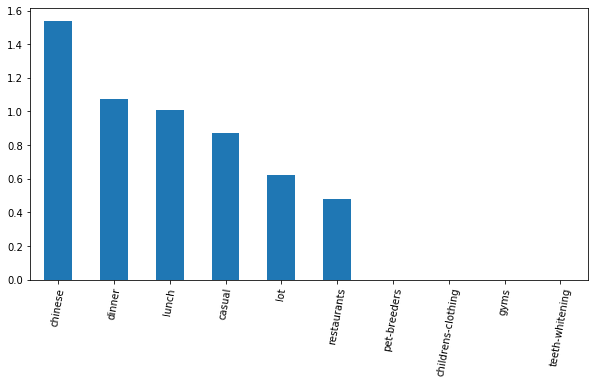

In [18]:
plt.rcParams['figure.figsize'] = [10, 5]

plot_data = pd.read_parquet(fp + "/" + fn + "_weighted.gzip")
which_rows = plot_data["business_id"] == "--6MefnULPED_I942VcFNA"
plot_data = plot_data[which_rows].squeeze()
plot_data = plot_data.drop("business_id").sort_values(ascending=False).head(10)
plot_data.plot.bar(x=plot_data.index, y=plot_data.values, rot=80)

In [19]:
plot_data = None